# GTSRB Classification with VGG-19

In [1]:
import os
import cv2
import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

## The data

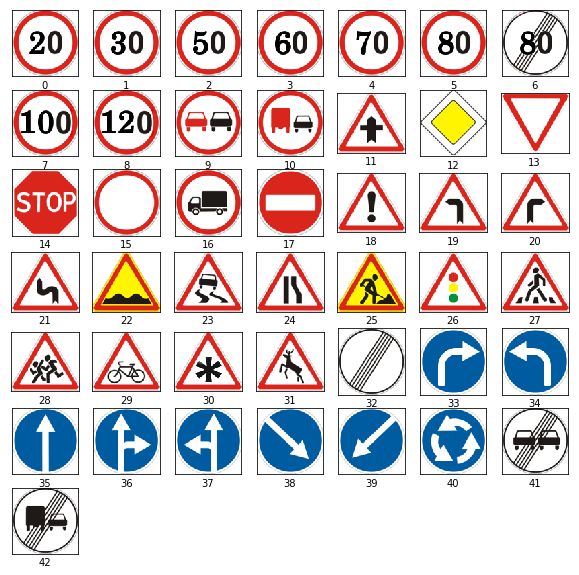

In [2]:
dir = '../germany_dataset'
    
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dir + "/meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

## Loading

In [3]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])        
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [4]:
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  16.42320156097412


## Network

In [5]:
classes = 43
batch = 256
epochs = 10
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

## Configuration

/raid/home/dgx1442/finalYearProject/venv/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
123/123 [==============================] - 719s 6s/step - loss: 1.1047 - accuracy: 0.7555 - val_loss: 1.0267 - val_accuracy: 0.9786
Epoch 2/10
123/123 [==============================] - 722s 6s/step - loss: 0.0724 - accuracy: 0.9903 - val_loss: 0.2133 - val_accuracy: 0.9881
Epoch 3/10
123/123 [==============================] - 732s 6s/step - loss: 0.0288 - accuracy: 0.9955 - val_loss: 0.0505 - val_accuracy: 0.9962
Epoch 4/10
123/123 [==============================] - 787s 6s/step - loss: 0.0135 - accuracy: 0.9983 - val_loss: 0.0190 - val_accuracy: 0.9974
Epoch 5/10
123/123 [==============================] - 794s 6s/step - loss: 0.0149 - accuracy: 0.9971 - val_loss: 0.0728 - val_accuracy: 0.9788
Epoch 6/10
123/123 [==============================] - 727s 6s/step - loss: 0.0198 - accuracy: 0.9952 - val_loss: 0.0198 - val_accuracy: 0.9953
Epoch 7/10
123/123 [==============================] - 731s 6s/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0061 - val_accuracy: 0.9986

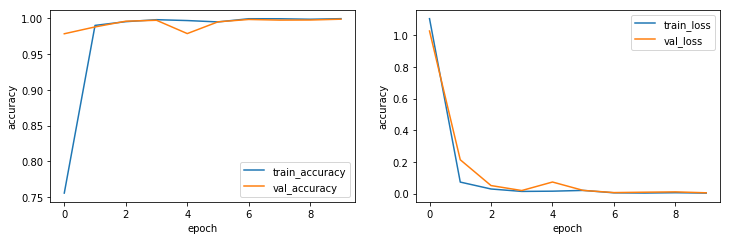

395/395 [==============================] - 22s 55ms/step - loss: 0.0769 - accuracy: 0.9777

Train time:  7114.638524055481
Test accuracy: 0.9776722192764282
Test loss: 0.0769193097949028
Test time:  22.12884211540222


In [6]:
model = Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)